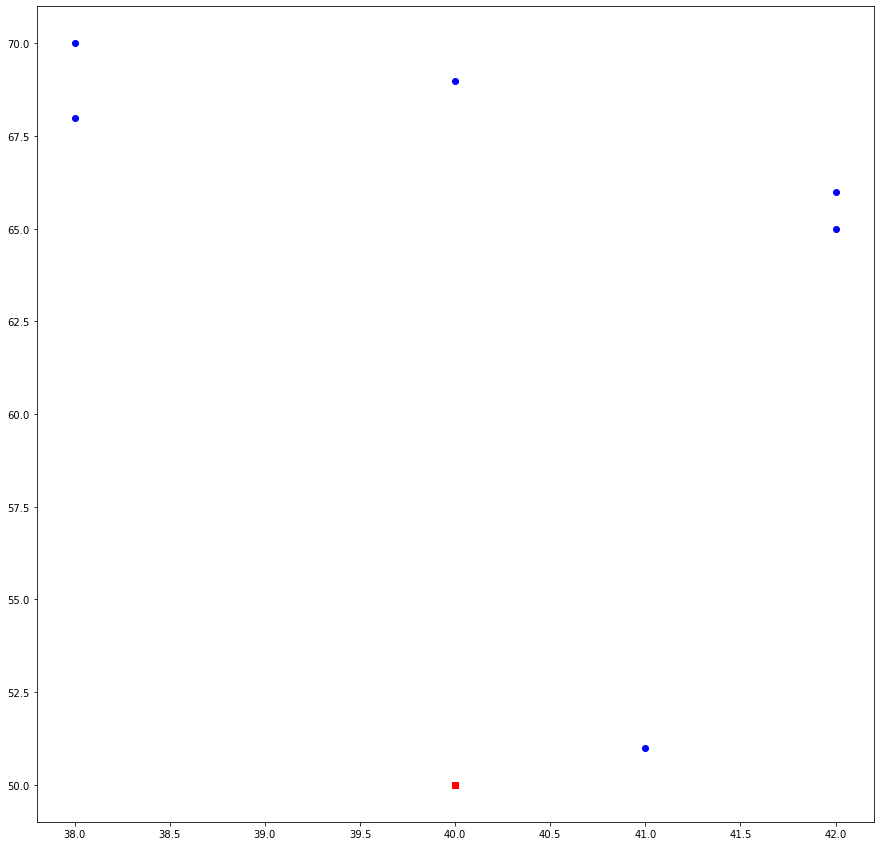

In [81]:
#Import packages
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt

#Load the data
data_small = np.loadtxt("data_small.txt", dtype='i')
data_large = np.loadtxt("data_large.txt", dtype='i')


#Problem
model = Model('Assignment_2B')

# Parameters of the model
d = data_small
number_of_vehicles = 2
# capacity per vehicle
Q = 60

X_COORD = []
for i in d[:,0]:
    X_COORD.append(d[i][1])
    
Y_COORD = []
for i in d[:,0]:
    Y_COORD.append(d[i][2])
    
q = []
for i in d[:,0]:
    q.append(d[i][3])
    
RT = []
for i in d[:,0]:
    RT.append(d[i][4])
    
DT = []
for i in d[:,0]:
    DT.append(d[i][5])
    
ST = []
for i in d[:,0]:
    ST.append(d[i][6])

# plot the nodes
plt.scatter(X_COORD[1:], Y_COORD[1:], c='b', marker='o')
plt.scatter(X_COORD[0], Y_COORD[0], c='r', marker='s')
# make the plot larger
plt.rcParams["figure.figsize"] = (15,15)
plt.show()

#Calculate Eucledian distance between the nodes
def c(i,j,data = d):
    distance = np.sqrt((d[i][1] - d[j][1]) ** 2 + (d[i][2] - d[j][2]) ** 2)
    return distance


Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 68 rows, 55 columns and 198 nonzeros
Model fingerprint: 0xe25fecda
Model has 30 general constraints
Variable types: 13 continuous, 42 integer (42 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
  GenCon rhs range [1e+01, 3e+01]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 68 rows and 55 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.09 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 80.6013 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.060131778324e+01, best bound 8.060131778324e+01, gap 0.0000%
[0.0, 146.0, 15.0, 702.0, 255.0, 605.0, 448.0]
[(4, 0), (0, 2), (6, 5), (3, 0), (5, 3), (2, 

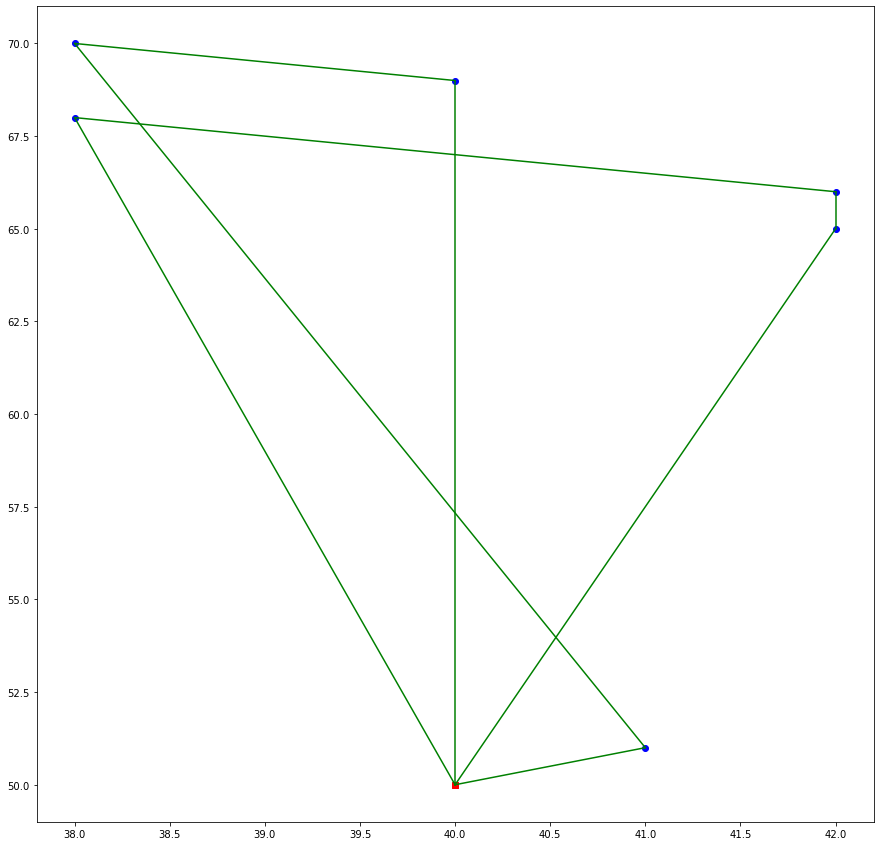

In [83]:
# sets
K = range(len(d))
V = number_of_vehicles
M = 10000
N = range(1,len(d))
A = {(i,j) for i in K for j in K if i != j}
C = {(i, j) : np.hypot(X_COORD[i] - X_COORD[j], Y_COORD[i] - Y_COORD[j]) for i, j in A}

# model
m = Model('CVRP')

# variables
x = m.addVars(A, vtype=GRB.BINARY, name='x')
u = m.addVars(N, vtype=GRB.CONTINUOUS, name='u')
t = m.addVars(K, vtype=GRB.CONTINUOUS, name='t')

# objective
m.setObjective(quicksum(C[i,j] * x[i,j] for i,j in A), GRB.MINIMIZE)

# constraints vechicles leaving depot
m.addConstrs(quicksum(x[i,j] for j in K if j != i) == 1 for i in N)
m.addConstrs(quicksum(x[i,j] for i in K if i != j) == 1 for j in N)

# start and end at depot
m.addConstr(quicksum(x[0,j] for j in N) == V)
m.addConstr(quicksum(x[i,0] for i in N) == V)

# demand satisfied constraint
m.addConstrs((x[i,j] == 1) >> (u[i] + q[j] == u[j]) for i,j in A if i != 0 and j != 0)

# capacity constraint
m.addConstrs((u[i] >= q[i]) for i in N)
m.addConstrs((u[i] <= Q) for i in N)

# time window constraints
m.addConstrs((t[i] >= RT[i]) for i in N)
m.addConstrs((t[i] <= DT[i]) for i in N)
m.addConstrs((t[i]+ C[i,j] + ST[i] - M*(1-x[i,j]) <= t[j]) for i,j in A if i != 0 and j != 0)


# model solution
m.optimize()

# make a matrix of the solution for t
t_sol = []
for i in K:
    t_sol.append(t[i].x)

print(t_sol)

# make plot
active_arcs = [a for a in A if x[a].x > 0.9]
print(active_arcs)

# make a matrix of the solution for u
u_sol = []
for i in N:
    u_sol.append(u[i].x)

print(u_sol)

# plot the solution
plt.scatter(X_COORD[1:], Y_COORD[1:], c='b', marker='o')
plt.scatter(X_COORD[0], Y_COORD[0], c='r', marker='s')
for i,j in active_arcs:
    plt.plot([X_COORD[i], X_COORD[j]], [Y_COORD[i], Y_COORD[j]], c='g')